In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data Preparation
df = pd.read_csv('C:\IBM\Tamilnadu power data.csv')
df['Parameter'] = pd.to_datetime(df['Parameter'])
df.columns = ['Date', 'Electricity']
df.set_index('Date', inplace=True)

In [3]:
# Add time-based features
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Day'] = df.index.day
df['DayOfWeek'] = df.index.dayofweek

In [4]:
# Function to create lag features
def create_lag_features(data, lags):
    for lag in lags:
        data[f'lag_{lag}'] = data['Electricity'].shift(lag)
    return data

df = create_lag_features(df, [1, 7, 14, 30])
df.dropna(inplace=True)


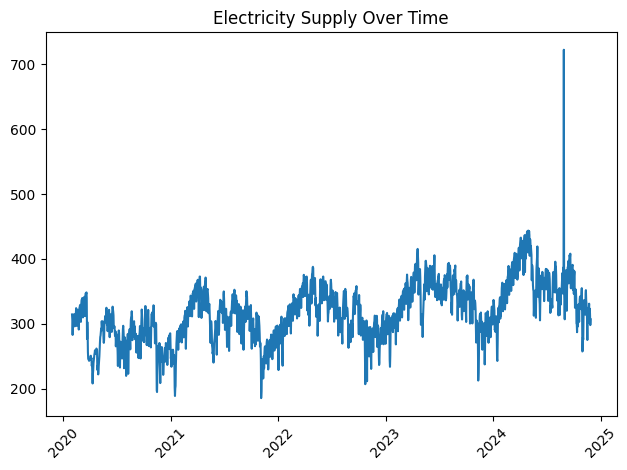

In [5]:
# 1. Time Series Plot
plt.plot(df.index, df['Electricity'])
plt.title('Electricity Supply Over Time')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts the layout to ensure everything fits without overlap
plt.show()


Text(0.5, 1.0, 'Monthly Distribution')

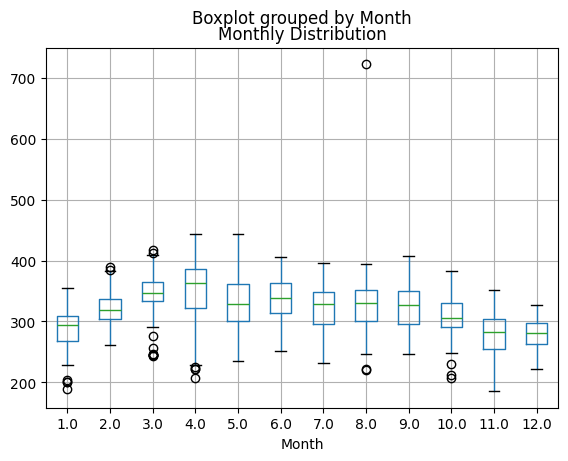

In [6]:
df.boxplot(column='Electricity', by='Month')
plt.title('Monthly Distribution')

Text(0.5, 1.0, 'Correlation Heatmap')

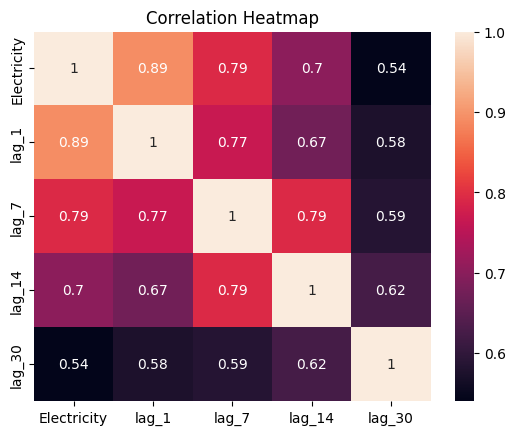

In [7]:
# 3. Correlation Heatmap
correlation = df[['Electricity', 'lag_1', 'lag_7', 'lag_14', 'lag_30']].corr()
sns.heatmap(correlation, annot=True)
plt.title('Correlation Heatmap')

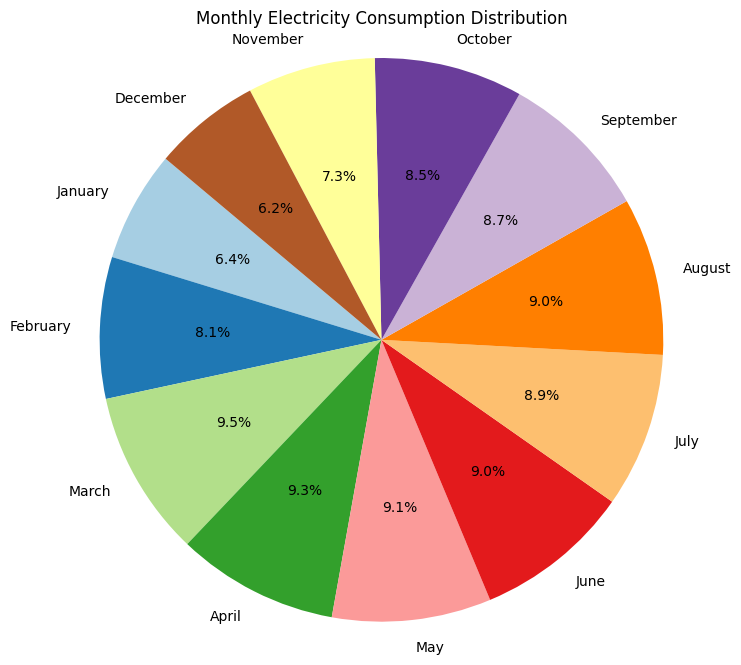

In [8]:
# 4. pie chart
df['Month'] = df.index.month_name()  # Extract month names from the DateTime index

# Group by the month and calculate the sum of 'Electricity' for each month
monthly_consumption = df.groupby('Month')['Electricity'].sum()
# Sort the months in calendar order
monthly_consumption = monthly_consumption[['January', 'February', 'March', 'April', 'May', 'June', 
                                           'July', 'August', 'September', 'October', 'November', 'December']]

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(monthly_consumption, labels=monthly_consumption.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Monthly Electricity Consumption Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

Text(0.5, 1.0, 'Yearly Trend')

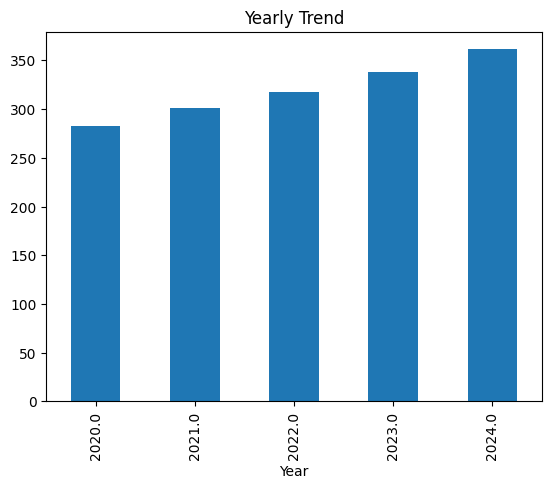

In [9]:
# 5. Yearly Trend
df.groupby('Year')['Electricity'].mean().plot(kind='bar')
plt.title('Yearly Trend')

Text(0.5, 1.0, 'Day of Week Pattern')

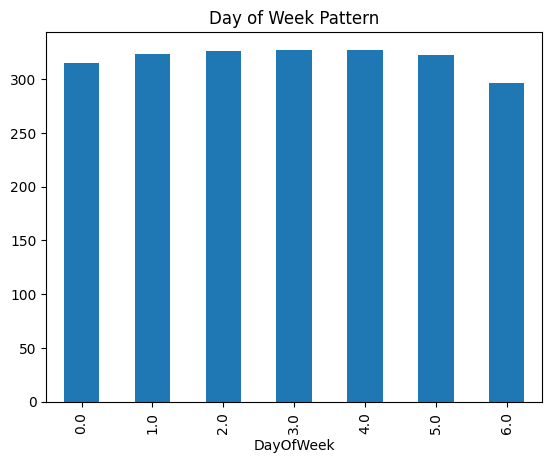

In [10]:
# 6. Day of Week Pattern
df.groupby('DayOfWeek')['Electricity'].mean().plot(kind='bar')
plt.title('Day of Week Pattern')

Text(0.5, 1.0, 'Lag Plot')

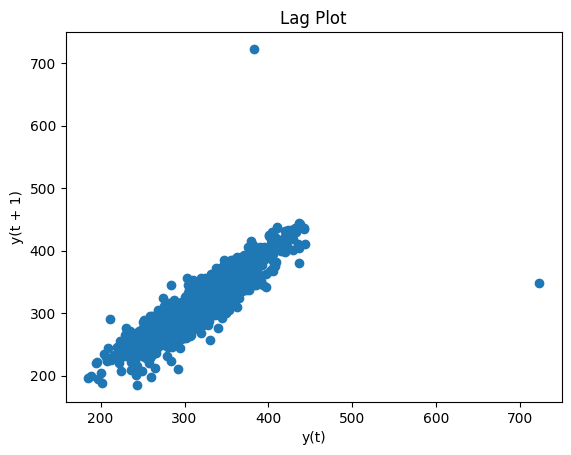

In [11]:
# 7. Lag Plot
pd.plotting.lag_plot(df['Electricity'])
plt.title('Lag Plot')

Text(0.5, 1.0, 'Distribution of Electricity Supply')

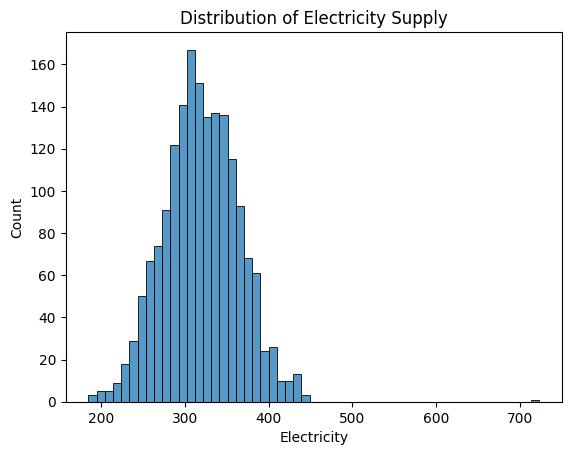

In [12]:
# 8. Distribution Plot
sns.histplot(df['Electricity'])
plt.title('Distribution of Electricity Supply')

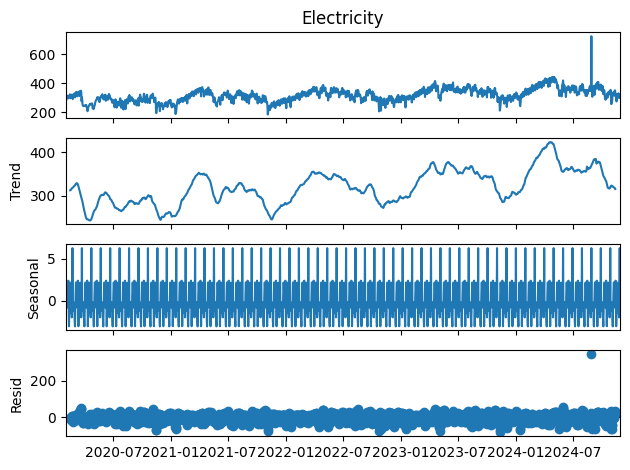

In [13]:
# 9. Seasonal Decomposition Plot
decomposition = seasonal_decompose(df['Electricity'], period=30)
decomposition.plot()
plt.tight_layout()

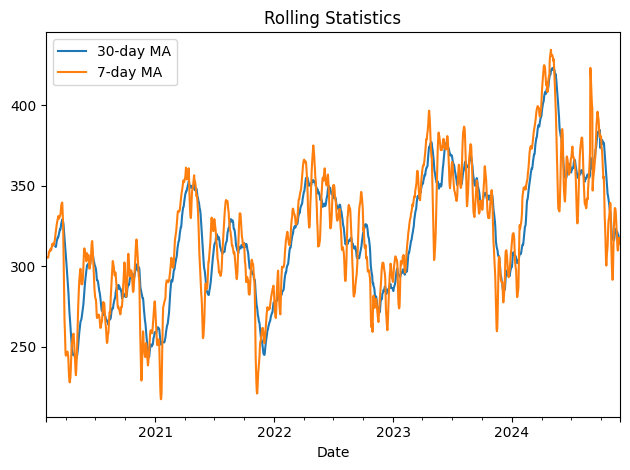

In [14]:
# 10. Rolling Statistics
df['Electricity'].rolling(window=30).mean().plot(label='30-day MA')
df['Electricity'].rolling(window=7).mean().plot(label='7-day MA')
plt.title('Rolling Statistics')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# K-Means Clustering
def perform_kmeans_analysis(data, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['Cluster'] = kmeans.fit_predict(data[['Electricity']])
    
    plt.figure(figsize=(12, 6))
    for i in range(n_clusters):
        cluster_data = data[data['Cluster'] == i]
        plt.scatter(cluster_data.index, cluster_data['Electricity'], label=f'Cluster {i}')
    plt.title('K-Means Clustering of Electricity Supply')
    plt.legend()
    plt.show()
    
    return kmeans

In [16]:
# ARIMA Model
def fit_arima(data):
    model = ARIMA(data['Electricity'], order=(1,1,1))
    results = model.fit()
    return results


In [17]:
# Exponential Smoothing
def fit_exponential_smoothing(data):
    model = ExponentialSmoothing(data['Electricity'], 
                                seasonal_periods=30,
                                trend='add',
                                seasonal='add')
    results = model.fit()
    return results


In [18]:
# Seasonal Decomposition
def perform_seasonal_decomposition(data):
    decomposition = seasonal_decompose(data['Electricity'], period=30)
    plt.figure(figsize=(12, 10))
    decomposition.plot()
    plt.tight_layout()
    plt.show()
    return decomposition

In [19]:
# Graph Neural Network
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [20]:
# Prepare data for modeling
X = df[['Month', 'Year', 'Day', 'DayOfWeek', 'lag_1', 'lag_7', 'lag_14', 'lag_30']]
y = df['Electricity'].values.astype('float32')


In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# Apply Label Encoding to 'Month' column
label_encoder = LabelEncoder()
X_train['Month'] = label_encoder.fit_transform(X_train['Month'])
X_test['Month'] = label_encoder.transform(X_test['Month'])

In [23]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
# Dictionary to store model performances
model_performances = {}


In [25]:
# Function to evaluate models
def evaluate_model(model, name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
        # Define a threshold for accuracy (e.g., 10% of the true value)
    threshold = 0.2
    accuracy = np.mean(np.abs((y_test - y_pred) / y_test) < threshold) * 100
    return {
        'name': name,
        'rmse': rmse,
        'r2': r2,
        'mae': mae,
        'accuracy': accuracy,
    }

In [26]:
# 1. GLM (Linear Regression)
lr_model = LinearRegression()
model_performances['GLM'] = evaluate_model(lr_model, 'GLM', X_train_scaled, X_test_scaled, y_train, y_test)

In [27]:
# 2. Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000)
model_performances['Neural Network'] = evaluate_model(nn_model, 'Neural Network', X_train_scaled, X_test_scaled, y_train, y_test)

In [28]:
# 3. Gradient Boosting
gb_model = GradientBoostingRegressor()
model_performances['Gradient Boosting'] = evaluate_model(gb_model, 'Gradient Boosting', X_train_scaled, X_test_scaled, y_train, y_test)


In [29]:
# 4. Decision Tree
dt_model = DecisionTreeRegressor()
model_performances['Decision Tree'] = evaluate_model(dt_model, 'Decision Tree', X_train_scaled, X_test_scaled, y_train, y_test)

In [30]:
# 5. Random Forest
rf_model = RandomForestRegressor()
model_performances['Random Forest'] = evaluate_model(rf_model, 'Random Forest', X_train_scaled, X_test_scaled, y_train, y_test)

In [31]:
# 6. SVM
svm_model = SVR()
model_performances['SVM'] = evaluate_model(svm_model, 'SVM', X_train_scaled, X_test_scaled, y_train, y_test)

In [32]:
# 7. k-NN
knn_model = KNeighborsRegressor()
model_performances['k-NN'] = evaluate_model(knn_model, 'k-NN', X_train_scaled, X_test_scaled, y_train, y_test)

In [33]:
# 9. AdaBoost (Boosting)
ada_model = AdaBoostRegressor()
model_performances['AdaBoost'] = evaluate_model(ada_model, 'AdaBoost', X_train_scaled, X_test_scaled, y_train, y_test)

In [34]:
# 10. Stacking
estimators = [
    ('rf', RandomForestRegressor()),
    ('gb', GradientBoostingRegressor()),
    ('nn', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000))
]
stack_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model_performances['Stacking'] = evaluate_model(stack_model, 'Stacking', X_train_scaled, X_test_scaled, y_train, y_test)

In [35]:
# Additional Time Series Models
# ARIMA
arima_model = fit_arima(df)
arima_pred = arima_model.forecast(steps=len(y_test))
# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - arima_pred) / y_test)) * 100
model_performances['ARIMA'] = {
    'name': 'ARIMA',
    'rmse': np.sqrt(mean_squared_error(y_test, arima_pred)),
    'r2': r2_score(y_test, arima_pred),
    'mae': mean_absolute_error(y_test, arima_pred),
    'accuracy': mape ,
}


In [36]:
# Exponential Smoothing
es_model = fit_exponential_smoothing(df)
es_pred = es_model.forecast(len(y_test))
mape = np.mean(np.abs((y_test - es_pred) / y_test)) * 100
model_performances['Exponential Smoothing'] = {
    'name': 'Exponential Smoothing',
    'rmse': np.sqrt(mean_squared_error(y_test, es_pred)),
    'r2': r2_score(y_test, es_pred),
    'mae': mean_absolute_error(y_test, es_pred),
    'accuracy': mape,
}


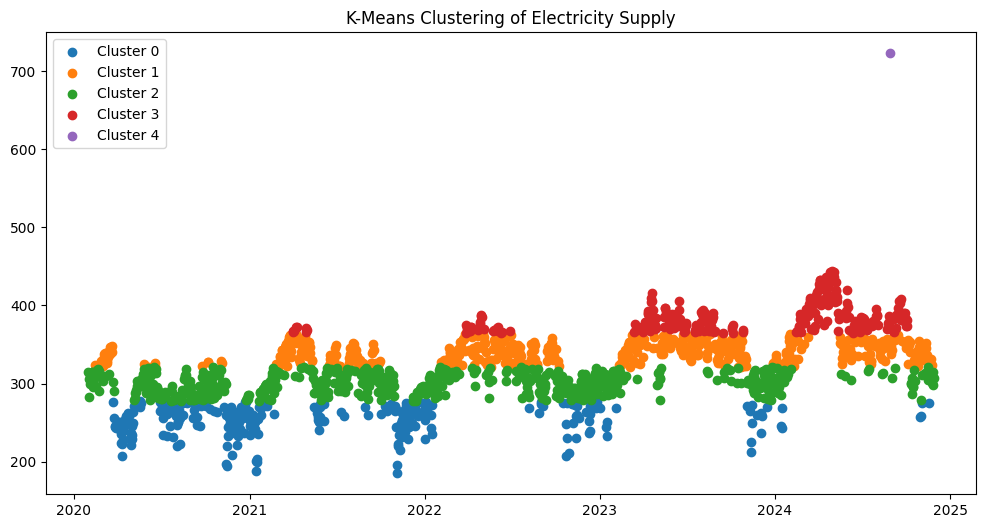

In [37]:
# K-Means Clustering Analysis
kmeans_model = perform_kmeans_analysis(df.copy())

<Figure size 1200x1000 with 0 Axes>

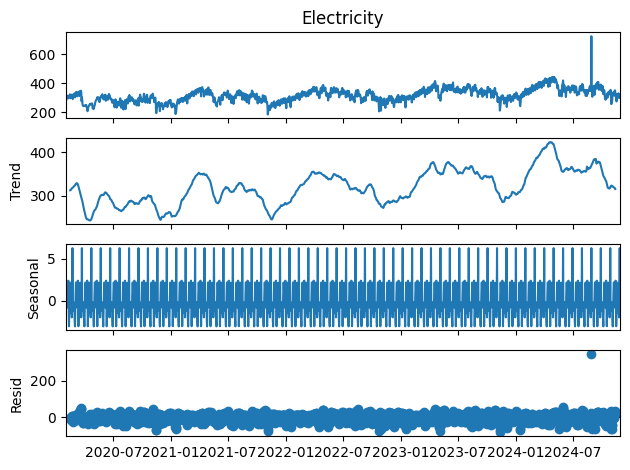

In [38]:
# Seasonal Decomposition Analysis
seasonal_decomp = perform_seasonal_decomposition(df)

In [39]:
y_train = pd.Series(y_train)
print(type(y_train.values))
print(y_train.values.shape)


<class 'numpy.ndarray'>
(1411,)


In [40]:
# Graph Neural Network
# Create graph structure
def create_graph_structure(data):
    # Create edges based on temporal relationships within training data
    edge_index = []
    for i in range(len(data) - 1):  # Ensure edges fit within data subset
        edge_index.append([i, i + 1])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()
# Create the edge_index for training data
edge_index = create_graph_structure(X_train_scaled)
# Filter edge_index to match training data size
edge_index = edge_index[:, edge_index.max(dim=0).values < len(X_train_scaled)]

x = torch.tensor(X_train_scaled, dtype=torch.float)
y_tensor = torch.tensor(y_train.values, dtype=torch.float)

gnn_model = GNNModel(X_train_scaled.shape[1], 64, 1)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [41]:
print(f"x shape: {x.shape}")  # Should match the number of nodes
print(f"edge_index max: {edge_index.max().item()}")  # Should be < len(x)


x shape: torch.Size([1411, 8])
edge_index max: 1410


In [42]:
# Train GNN
for epoch in range(100):
    optimizer.zero_grad()
    out = gnn_model(x, edge_index)
    loss = criterion(out.squeeze(), y_tensor)
    loss.backward()
    optimizer.step()

In [43]:
def create_graph_structure_for_test(data_length):
    # Create edges for test data only
    edge_index = []
    for i in range(data_length - 1):
        edge_index.append([i, i + 1])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create edge_index for the test set
test_edge_index = create_graph_structure_for_test(len(X_test_scaled))
x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)



In [44]:
gnn_model.eval()
with torch.no_grad():
    gnn_pred = gnn_model(x_test_tensor, test_edge_index).numpy()
# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - gnn_pred) / y_test)) * 100

# Calculate performance metrics
model_performances['GNN'] = {
    'name': 'GNN',
    'rmse': np.sqrt(mean_squared_error(y_test, gnn_pred)),
    'r2': r2_score(y_test, gnn_pred),
    'mae': mean_absolute_error(y_test, gnn_pred),
    'accuracy': mape,
}


In [45]:
# Print model performances
performance_df = pd.DataFrame(model_performances).T
print("\nModel Performances:")
print(performance_df)



Model Performances:
                                        name        rmse        r2  \
GLM                                      GLM   21.534015  0.781299   
Neural Network                Neural Network   24.258817  0.722451   
Gradient Boosting          Gradient Boosting    12.68813  0.924073   
Decision Tree                  Decision Tree   17.329684  0.858361   
Random Forest                  Random Forest   14.048185  0.906923   
SVM                                      SVM   22.401505  0.763324   
k-NN                                    k-NN   16.087378  0.877941   
AdaBoost                            AdaBoost   17.817373  0.850277   
Stacking                            Stacking   15.840129  0.881664   
ARIMA                                  ARIMA   46.816293 -0.033699   
Exponential Smoothing  Exponential Smoothing   89.234262 -2.755462   
GNN                                      GNN  173.944031 -13.26984   

                              mae   accuracy  
GLM                  

In [46]:
# Find best model
best_model_name = performance_df['r2'].idxmax()
print(f"\nBest Model: {best_model_name}")


Best Model: Gradient Boosting


In [47]:
# Future predictions using best model
# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=90, freq='D')

# Create features for future dates
future_df = pd.DataFrame(index=future_dates)
future_df['Month'] = future_df.index.month
future_df['Year'] = future_df.index.year
future_df['Day'] = future_df.index.day
future_df['DayOfWeek'] = future_df.index.dayofweek

# Use last known values for lag features
future_df['lag_1'] = df['Electricity'].iloc[-1]
future_df['lag_7'] = df['Electricity'].iloc[-7]
future_df['lag_14'] = df['Electricity'].iloc[-14]
future_df['lag_30'] = df['Electricity'].iloc[-30]

In [48]:
# Scale future features
future_features_scaled = scaler.transform(future_df)

# Make predictions using the Gradient Boosting model
if best_model_name == 'Gradient Boosting':
    future_predictions = gb_model.predict(future_features_scaled)  # Using the Gradient Boosting model for prediction

# Create predictions DataFrame
predictions_df = pd.DataFrame(index=future_dates, data={'Predicted_Electricity': future_predictions})


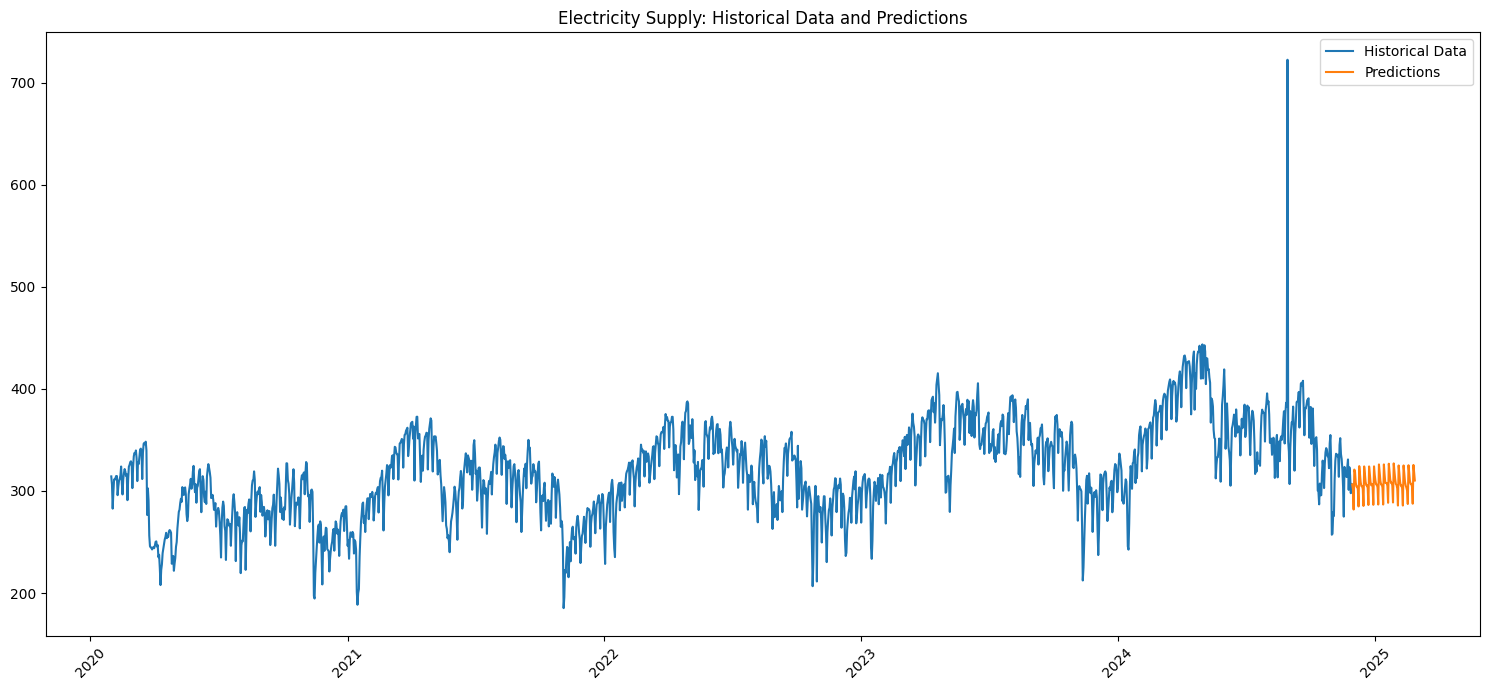

In [49]:
# Visualize predictions
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Electricity'], label='Historical Data')
plt.plot(predictions_df.index, predictions_df['Predicted_Electricity'], label='Predictions')
plt.title('Electricity Supply: Historical Data and Predictions')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

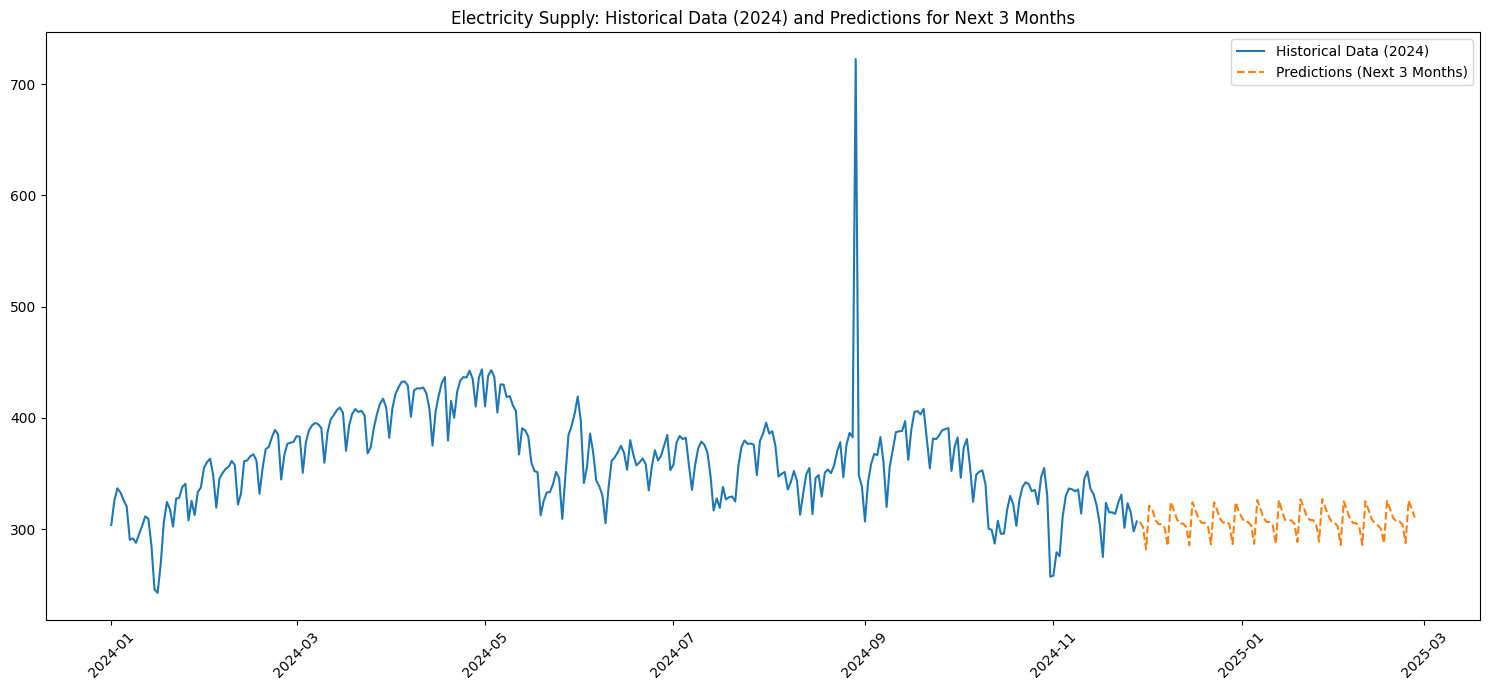

In [50]:
df_2024 = df[df.index.year == 2024]
# Visualize historical data for 2024 and predictions for the next 3 months
plt.figure(figsize=(15, 7))
plt.plot(df_2024.index, df_2024['Electricity'], label='Historical Data (2024)')

# Plot predictions for the next 3 months
plt.plot(predictions_df.index, predictions_df['Predicted_Electricity'], label='Predictions (Next 3 Months)', linestyle='--')

# Add title and labels
plt.title('Electricity Supply: Historical Data (2024) and Predictions for Next 3 Months')
plt.legend()
plt.xticks(rotation=45)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [51]:
print("\nPredictions for next 3 months:")
print(predictions_df.head(90))


Predictions for next 3 months:
            Predicted_Electricity
2024-11-29             306.359426
2024-11-30             301.750977
2024-12-01             281.831656
2024-12-02             320.961096
2024-12-03             318.193017
...                           ...
2025-02-22             304.162422
2025-02-23             287.528704
2025-02-24             325.520543
2025-02-25             318.298341
2025-02-26             310.304330

[90 rows x 1 columns]


In [52]:
# Save predictions to CSV
predictions_df.to_csv('electricity_predictions.csv')